# Induction detection

This is a test notebook for the reconstruction frame. Pure and spurious induction signal are detected

In [ ]:
from TMSAnalysis.StruckAnalysisConfiguration import StruckAnalysisConfiguration
from TMSAnalysis.WaveformAnalysis import Waveform
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import uproot

plt.rcParams['figure.figsize'] = [9, 8]
plt.rcParams['font.size'] = 15

In [90]:
run_parameters_file = '/g/g90/jacopod/software/TMSAnalysis/config/Run_Parameters_Xe_Run29.csv'
calibrations_file = '/g/g90/jacopod/software/TMSAnalysis/config/Calibrations_Xe_Run11b.csv'
channel_map_file = '/g/g90/jacopod/software/TMSAnalysis/config/Channel_Map_Xe_Run29.csv'

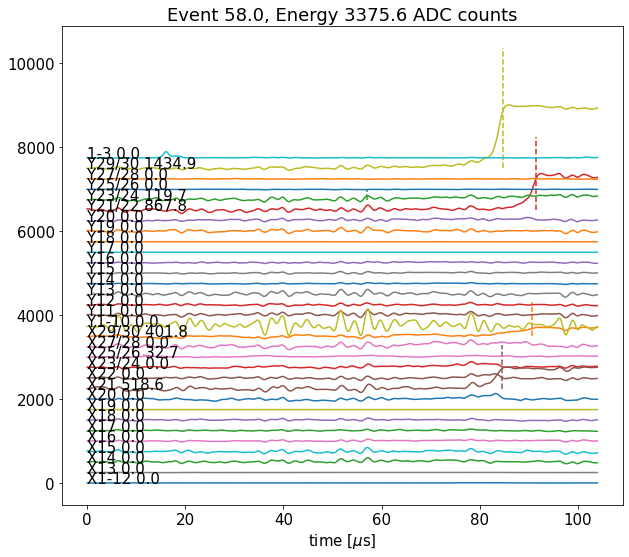

In [101]:
event_num = 58
path = '/p/lustre1/jacopod/29th/20200213_AfterRnInjection/tier1'
fname = '/p/lustre1/jacopod/29th/analysis_500ns/20200213_AfterRnInjection/tier1_SIS3316Raw_20200214111325_SiPMs_longTPC_sbias32_scope_trig13_36mV_cath_6kV_1-ngm_reduced.h5'
df = pd.read_hdf(fname, start=event_num, stop=event_num+1)
#for k in df.keys():
#    print(k)
event = Waveform.Event(fname,path,event_num,\
                       run_parameters_file,\
                       calibrations_file,\
                       channel_map_file)
event.smooth(0.5)
plot = event.plot_event(risetime=True)
plot.show()

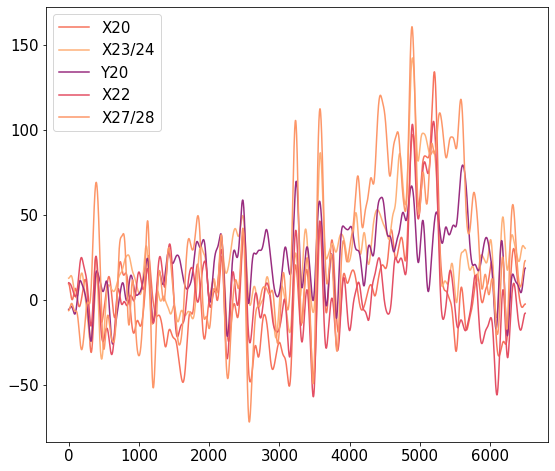

In [102]:
wfm_samples = 6500
induction_window_us = 4
sampling_period_us = 0.016
induction_window_sample = int(induction_window_us/sampling_period_us)
color = []
wfm_induction = []
label = []
for i,k in enumerate(event.waveform.keys()):
    if 'X' not in k and 'Y' not in k:
        continue
    baseline = df['TileStrip {} Baseline'.format(k)].values[0]
    baseline_rms = df['TileStrip {} Baseline RMS'.format(k)].values[0]
    event.charge_energy_ch[i]
    buffer_array = np.zeros(wfm_samples)
    above_rms = np.where(event.waveform[k].data-baseline>\
                         (event.charge_energy_ch[i]+3*baseline_rms))[0]
    buffer_array[above_rms] = 1
    tag = np.sum(buffer_array.reshape(-1,induction_window_sample),axis=1)
    induction_tag = np.where(tag>0.8*induction_window_sample)[0]
    if induction_tag.shape[0] == 0:
        continue
    else:
        lower_bin = (induction_tag[-1]-1)*induction_window_sample
        higher_bin = (induction_tag[-1]+1)*induction_window_sample
    average_charge_ind = sum((event.waveform[k].data-baseline)\
          [lower_bin:higher_bin])/(higher_bin-lower_bin)
    if average_charge_ind<30:
        continue
    wfm_induction.append(event.waveform[k].data-baseline)
    color.append(average_charge_ind)
    label.append(k)
    
if len(color)>0:
    colors = plt.cm.magma(np.asarray(color)/(1.2*max(color)))    
    for i,e in enumerate(wfm_induction):
        plt.plot(e,label=label[i],color=colors[i])
plt.legend()
plt.show()

the condition for induction is that the waveform has to be stay above 3 times the noise (offset for a possible collection) for and interval of time induction_window_us=4us. To detect that I chuck the waveform in intervals of induction_window_us and for each chuck I check that at least 80% of it is above this threshold. Finally, since the maximum induced charge is too jittery, I calculate the average induced charge over 2 induction windows